# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
X.X     | XX/XX/2022 | A.B        | modif
1.1     | 04/07/2022 | I.S, H.A.  | Anomaly one-hot encoding
1.0     | 30/06/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly
* A comparison of 2 approaches (Naive vs Regex, more complex) was performed, but, with very limited discrepancies between the 2 approaches, we favored the naive one (see : ATTEMPT_1_main_DO_NOT_MODIFY_20220704_Anomaly_ReGex.ipynb).  

Further processing of the data should be perfomed on this dataframe, after having **copied a version of the present notebook**.

# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [3]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer

###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

# EVALUATION tools from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

###############################
# Deep Learning
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import callbacks


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD FUNCTIONS

Functions common to several sections of this code (we should actually put them in a separate file and load them from there)

In [4]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

# LOAD DATA

## Mount GDrive

In [5]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [6]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [7]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [8]:
#@title
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("train_data_final.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data[0]
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 97417 entries has been loaded


# NARRATIVE ENGINEERING

### Load the pre-processed Narrative data 

See the notebook that performs the substitutions

In [9]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_PP_stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_PP_stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [10]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_Raw_Stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_Raw_Stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [11]:
df.loc[1715282]['Narrative']

"I am writing this report to bring attention to the second departure frequency out of MDW last night. It is a safety issue to give us two frequency changes below 3;000 feet on departure out of MDW.We were in a heavy [aircraft] doing a full power; flaps 25; bleeds off takeoff off of 22L. These takeoffs are known to have very high climb rates; so the intermediate level-off of 3;000 feet approaches fast. At 1;000 feet; we're instructed to contact Departure on 128.2. Simultaneously; I switch frequencies and retract flaps as commanded by the pilot flying. Upon checking in with 128.2; he instructs us to climb and maintain 4;000 feet and subsequently contact 126.62. I dial in 4;000 feet and continue to retract flaps while monitoring a level-off from a climb rate of over 2;000 FPM. At this point; my head turns down to the radio to dial the new Departure frequency in. I check in and they tell us to climb and maintain 12;000 feet. I dial in 12;000 feet; confirm it; reset the autobrake and gear l

In [12]:
df.loc[1715282]['Narrative_PP_stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

In [13]:
df.loc[1715282]['Narrative_Raw_Stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

# TARGET FEATURE ENGINEERING

## Anomaly

This section 

*   drops the entries with NaN in 'Anomaly'
*   creates and adds to the DataFrame 'df' a one-hot column for each Anomaly root label

Root labels are as defined in the ASRS coding form.pdf

We use a naive approach using string parsing 

### Drop the NaNs in Anomaly

In [14]:
# Drop Anomaly NaN's
print(f"We have {len(df[df['Anomaly'].isna()])} entries where 'Anomaly' == NaN. We drop these entries")

df = df.dropna(axis = 0, how = 'any', subset = ['Anomaly'])
print(f"Current length of our DataFrame: {len(df)}")

We have 431 entries where 'Anomaly' == NaN. We drop these entries
Current length of our DataFrame: 96986


### One-hot encode Anomaly root labels

In [15]:
# Root label (source = ASRS coding forms)
Anomaly_RootLabels=['Aircraft Equipment',
                    'Airspace Violation',
                    'ATC Issue',
                    'Flight Deck / Cabin / Aircraft Event',
                    'Conflict',
                    'Deviation - Altitude',
                    'Deviation - Speed',
                    'Deviation - Track / Heading',
                    'Deviation / Discrepancy - Procedural',
                    'Ground Excursion',
                    'Ground Incursion',
                    'Ground Event / Encounter',
                    'Inflight Event / Encounter',
                    'No Specific Anomaly Occurred']

#### Naive one-hot encoding

In [16]:
# Create a column in the df corresponding to each Anomaly root label 'anomaly_rl'
Anomaly_RootLabels_columns = []
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_' + anomaly_rl
    Anomaly_RootLabels_columns.append(col)
    # Fill the columns in a one-hot-encoding logic
    df[col] = df['Anomaly'].astype('str').apply(lambda x: 1 if (anomaly_rl in x)  else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [17]:
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_'+anomaly_rl
    print('\n',col,'\n',df[col].value_counts())


 Anomaly_Aircraft Equipment 
 0    59054
1    37932
Name: Anomaly_Aircraft Equipment, dtype: int64

 Anomaly_Airspace Violation 
 0    92989
1     3997
Name: Anomaly_Airspace Violation, dtype: int64

 Anomaly_ATC Issue 
 0    81232
1    15754
Name: Anomaly_ATC Issue, dtype: int64

 Anomaly_Flight Deck / Cabin / Aircraft Event 
 0    89839
1     7147
Name: Anomaly_Flight Deck / Cabin / Aircraft Event, dtype: int64

 Anomaly_Conflict 
 0    79622
1    17364
Name: Anomaly_Conflict, dtype: int64

 Anomaly_Deviation - Altitude 
 0    88110
1     8876
Name: Anomaly_Deviation - Altitude, dtype: int64

 Anomaly_Deviation - Speed 
 0    94398
1     2588
Name: Anomaly_Deviation - Speed, dtype: int64

 Anomaly_Deviation - Track / Heading 
 0    88707
1     8279
Name: Anomaly_Deviation - Track / Heading, dtype: int64

 Anomaly_Deviation / Discrepancy - Procedural 
 1    58337
0    38649
Name: Anomaly_Deviation / Discrepancy - Procedural, dtype: int64

 Anomaly_Ground Excursion 
 0    94829
1     

In [18]:
# Plots
# # Parsing de la colonne 'Anomaly' et top 200 des modalités selon le 1/0 encoding
# for anomaly_rl in Anomaly_RootLabels:
#     col='Anomaly_'+anomaly_rl
    
#     title_plot=col +' : ' + str(sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==1]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='green').set(title=title_plot);

#     title_plot='NO '+col +' : ' + str(len(df)-sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==0]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='red').set(title=title_plot);

# Padding ratio

Some statistical considerations concerning narrative length (measured in # of tokens) vs. pad length.


Usefull for WordEmbedding algorithms

In [ ]:
# Examine typical narrative length to get an idea about the padding / truncating step
df['Narrative_PP_stemmed_len'] = df['Narrative_PP_stemmed'].apply(lambda x: len(x))
df['Narrative_PP_stemmed_len'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    96986.000000
mean       143.628379
std        106.181102
min          1.000000
25%         72.000000
50%        117.000000
75%        185.000000
max       1317.000000
Name: Narrative_PP_stemmed_len, dtype: float64

Positive: narrative is longer than maxlen; there is no padding

Negative: narrative is shorter than maxlen; we have padding.

the more negative the ratio, the more padding there is. It cannot get more negative than -1.0



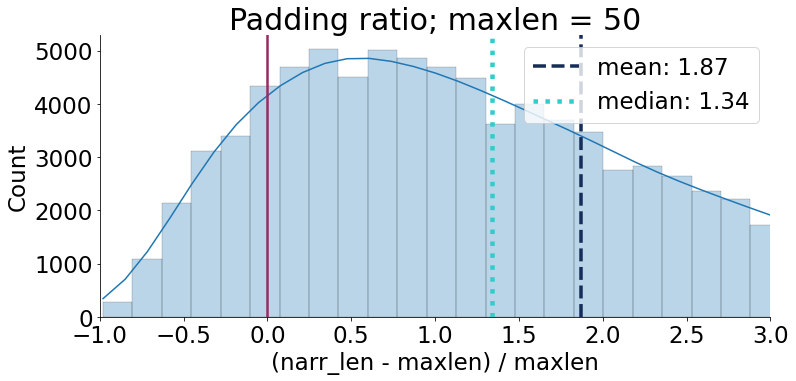

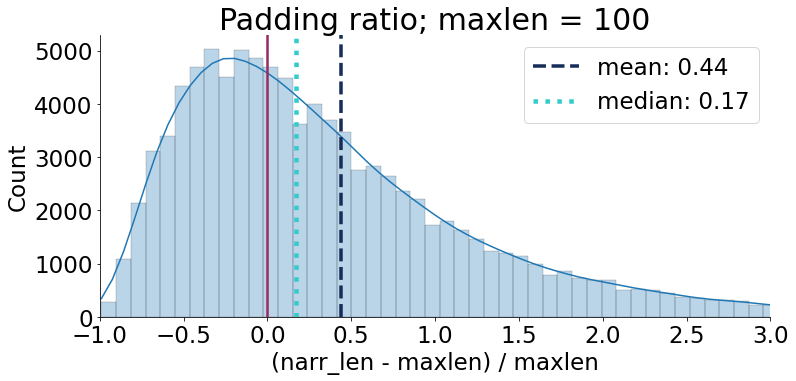

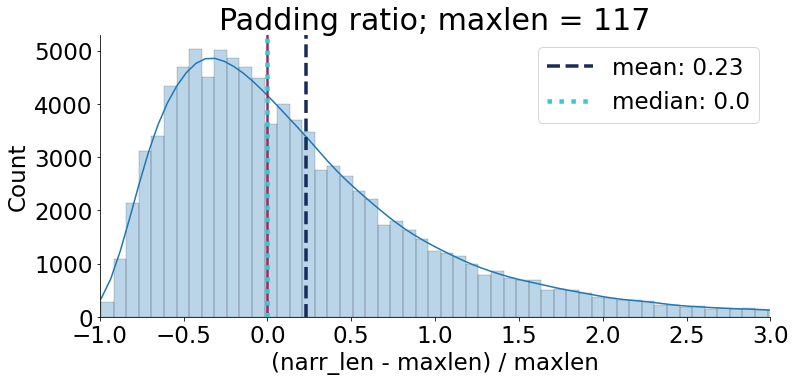

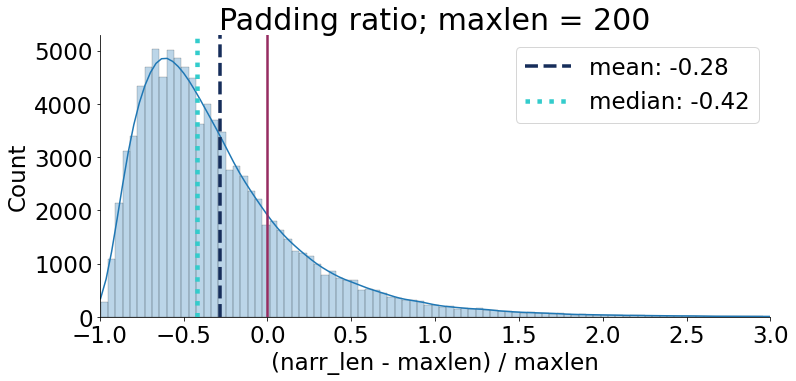

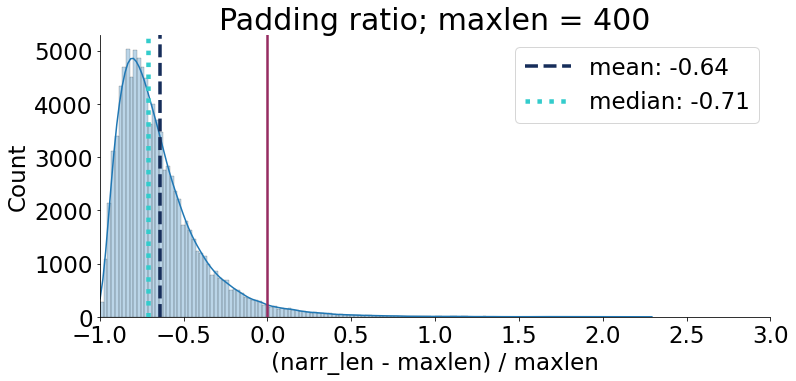

In [ ]:
maxlen = 200 # length of the text vector (in words). Will ignore narrative content beyond this limit

# Plot histograms
print("Positive: narrative is longer than maxlen; there is no padding\n")
print("Negative: narrative is shorter than maxlen; we have padding.\n")
print("the more negative the ratio, the more padding there is. It cannot get more negative than -1.0\n")

for maxlen in [50, 100, 117, 200, 400]:
  pad_ratio = df['Narrative_PP_stemmed_len'].apply(lambda x: (x - maxlen) / maxlen)

  sns.displot(pad_ratio, bins = 150, kde = True, alpha  = 0.3)
  plt.xlim([-1,3])
  plt.gcf().set_size_inches(15, 5)

  # Plot mean, median as vertical lines
  mean = np.round(pad_ratio.mean(),2)
  median = np.round(pad_ratio.median(),2)
  plt.axvline(x = 0, color = '#962c61', ls='-', lw = 2.5)
  plt.axvline(x = mean, color = '#162d5a', ls='--', lw = 3.5, label = f'mean: {mean}')
  plt.axvline(x = median, color = '#33cccc', ls='dotted', lw = 4.5, label = f'median: {median}')

  plt.xlabel('(narr_len - maxlen) / maxlen')
  plt.title(f'Padding ratio; maxlen = {maxlen}')
  plt.legend();

# 🤗 Hugging Face 

In [ ]:
! pip install transformers 
! pip install datasets 
! pip install huggingface_hub

## One vs. all Word Embedding - loop over Anomalies

## Prepare a 🤗 dataset

### Convert to a 🤗 dataset

In [20]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
anomaly_name = 'Anomaly_Conflict'
temp_df = df[['Narrative_PP_stemmed_str', anomaly_name]].rename(columns = {'Narrative_PP_stemmed_str': 'text', 'Anomaly_Conflict': 'label'})
temp_df = temp_df.reset_index().drop(columns = ['ACN'])

num_classes = 2
# One-hot encode tha labels into the format [0,1] and [1,0]
temp_df['label'] = temp_df['label'].apply(lambda x: to_categorical(x, num_classes = num_classes))


In [22]:
# Train-test split  
temp_df_train_plus_val, temp_df_test, = train_test_split(temp_df, 
                                                test_size= 0.2,
                                                random_state = 12) 

# temp_df_train, temp_df_test, = train_test_split(temp_df, 
#                                                 test_size= 0.2,
#                                                 random_state = 12) 

# Train-validation split 
temp_df_train, temp_df_validation, = train_test_split(temp_df_train_plus_val, 
                                                test_size= 0.2,
                                                random_state = 12) 

temp_df_train.head(3)

print("train set length:", len(temp_df_train))
print("validation set length:", len(temp_df_validation))
print("test set length:", len(temp_df_test))

train set length: 62070
validation set length: 15518
test set length: 19398


In [23]:
from datasets import Dataset, DatasetDict
# use from_dict() and not from_pandas(); otherwise you get an extra key, smth litke '__index col__'
train_dataset = Dataset.from_dict(temp_df_train)
validation_dataset = Dataset.from_dict(temp_df_validation)
test_dataset = Dataset.from_dict(temp_df_test)

# inspect this object
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 62070
})

In [24]:
# Inspect the label format
train_dataset['label'][:3]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]

In [25]:
# 'merge' the two 🤗 datasets into one
dataset = DatasetDict({"train": train_dataset, 
                       "validation": validation_dataset, 
                       "test": test_dataset})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 62070
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 15518
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 19398
    })
})

In [26]:
# Inspect the two keys
print(dataset['train'].features)
print(dataset['validation'].features)
print(dataset['test'].features, '\n')

# To access an actual element, select a split first, then give an index:
print(dataset["train"][0])

{'text': Value(dtype='string', id=None), 'label': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}
{'text': Value(dtype='string', id=None), 'label': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}
{'text': Value(dtype='string', id=None), 'label': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)} 

{'text': 'work radar citat x descend sef airport pilot approxim 10-12 mile away airport report field sight clear aircraft visual approach issu clearanc termin radar servic clear airport advisori frequenc thought aircraft close enough field proceed straight land instead aircraft took hard left turn expect presum set land whichev runway use hard left turn put aircraft proxim r2901a activ surfac 070 sure close got even offici violat airspac nonetheless unsaf opinion tri sever time rais aircraft frequenc unsuccess due either aircraft low altitud unicom frequenc monitor mine sever thing would recommend help avoid situat first pilot 

### Tokenize with pretrained tokenizer

In [27]:
# TOKENIZE using a pre-trained tokenizer from HuggingFace
from transformers import AutoTokenizer

# Name of the BERT model to use
model_name = 'bert-base-uncased'

# instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define a function in order to use .map() below
max_length = 200
def tokenize_function(examples):
  return tokenizer(examples["text"], 
                    padding='max_length', max_length = max_length, # same value as we used for WordEmbedding 
                    truncation = True
                    #return_tensors="tf"
                    )

# Auxialiary variable, see below
pre_tokenizer_columns = set(dataset["train"].features)

# map the tokenization function onto our dataset
# it is ok to apply it also to the test set, since it is a *pretrained* tokenizer,
# i.e. it will not train on our data
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Display the additional columns created by the tokenizer
# They are necessary inputs for BERT
tokenizer_columns = list(set(tokenized_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/63 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

Columns added by tokenizer: ['token_type_ids', 'attention_mask', 'input_ids']


In [28]:
# inspect 
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 62070
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15518
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19398
    })
})

## Fine-tuning the model

### Download the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the TFAutoModelForSequenceClassification class. Like with the tokenizer, the from_pretrained method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem

In [29]:
from transformers import TFAutoModelForSequenceClassification

# num_labels = 2 # binary classification
# model_checkpoint = "distilbert-base-uncased"

# model = TFAutoModelForSequenceClassification.from_pretrained(
#     model_checkpoint, num_labels = num_labels
# )

In [30]:
# model.summary()

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

#### Alternative: use BertConfig

CODE FROM JENSEN's TUTORIAL; ADAPT IT


From [HuggingFace](https://huggingface.co/docs/transformers/model_doc/bert): 

BertConfig is the configuration class to store the configuration of a BertModel (Pytorch) or a TFBertModel (TensorFlow). It is used to instantiate a BERT model according to the specified arguments, defining the model architecture. Instantiating a configuration with the defaults will yield a similar configuration to that of the BERT bert-base-uncased architecture.

Configuration objects inherit from PretrainedConfig and can be used to control the model outputs. Read the documentation from PretrainedConfig for more information.

Difference between AutoConfig, AutoTokenizer etc. vs. BertConfig, BertTokenizer etc.:

[forum entry](https://github.com/huggingface/transformers/issues/5587) --> Use AutoXXX for more flexibility regarding model checkpoints

In [31]:
#########################################
# CODE FROM JENSEN's TUTORIAL; ADAPT IT
#########################################

from transformers import AutoConfig

# Load transformers config and set output_hidden_states to False
config = AutoConfig.from_pretrained(model_name)
# AutoClasses automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary.
config.output_hidden_states = False
config.num_labels = num_classes # here 2, since binary classification


In [32]:
# # Load BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

from transformers import TFAutoModel
# Loading a model from its configuration file does not load the model weights. 
# It only affects the model’s configuration. Use from_pretrained() to load the model weights

# Load the Transformers BERT model
transformer_model = TFAutoModel.from_pretrained(model_name, config = config) # pass our configuration

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
# Max length of tokens
max_length = 200

# Load the MainLayer
bert = transformer_model.layers[0] # I think the [0] is obsolete, since there is only 1 element

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
# attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
# inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
inputs = {'input_ids': input_ids}

In [34]:
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1] # OR bert_model = bert(inputs) ???
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

In [35]:
from keras.initializers import TruncatedNormal # Initializer that generates a truncated normal distribution.

# Then build your model output
#flattened_output = GlobalAveragePooling1D()(pooled_output)
anomaly_class = Dense(units = 2, 
                      #activation = 'relu',
                      kernel_initializer = TruncatedNormal(stddev=config.initializer_range), 
                      name='dense1')(pooled_output)

#anomaly_class = Dense(units = 2, activation = 'sigmoid')(dropout2_output) # 2 units, because BINARY classification problem

# Combine it all in a model object
model = Model(inputs=inputs, outputs = anomaly_class, name='BERT_BINARY_classification')

# Take a look at the model
model.summary()

Model: "BERT_BINARY_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 200)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

### Convert dataset to TensorFlow format

Next, we convert our datasets to `tf.data.Dataset`, which Keras understands natively. There are two ways to do this - we can use the slightly more low-level [`Dataset.to_tf_dataset()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method, or we can use [`Model.prepare_tf_dataset()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset). The main difference between these two is that the `Model` method can inspect the model to determine which column names it can use as input, which means you don't need to specify them yourself. Unless our samples are all the same length, we will also need to pass a `tokenizer` or `collate_fn` so that the `tf.data.Dataset` knows how to pad and combine samples into a batch.

In [36]:
# Convert Huggingface datasets to TF datasets
batch_size=16

tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    shuffle=True,
    batch_size=batch_size)

tf_validation_dataset = tokenized_dataset["validation"].to_tf_dataset(
    shuffle=False,
    batch_size=batch_size)

tf_test_dataset = tokenized_dataset["test"].to_tf_dataset(
    shuffle=False,
    batch_size=batch_size)

In [37]:
tf_train_dataset

<PrefetchDataset element_spec={'text': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'label': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), 'input_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)}>

### Compile & Fit

In [38]:
# Set an optimizer; see HuggingFace tutorial for AdamW alternative
optimizer = keras.optimizers.Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True) 
# value in [-inf, inf] when from_logits=True) or a probability (i.e, value in [0., 1.] when from_logits=False).

metric = tf.keras.metrics.BinaryAccuracy('accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)


In [39]:
# Define CALLBACKS
TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

early_stopping = callbacks.EarlyStopping(monitor = 'val_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                        min_delta=0.01,
                                        patience = 3, 
                                        mode = 'max', 
                                        restore_best_weights = True, 
                                        verbose = 1)

In [ ]:
num_epochs = 10
training_history = model.fit(x = tokenized_dataset["train"]['input_ids'],
                             y = tokenized_dataset["train"]['label'],
                             validation_data = (tokenized_dataset["validation"]['input_ids'], tokenized_dataset["validation"]['label']),
                             epochs=num_epochs, 
                             callbacks = [TON, early_stopping],
                             verbose = 2)
# Works when using only 20,000 input data and crashes for entire dataset.
# Use datagen or tf.dataset ?

# Takes time to show epoch progression

Epoch 1/10


In [ ]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

In [ ]:
# Plot the train history
plot_train_history(training_history, 'accuracy', anomaly_name)
plot_train_history(training_history, 'loss', anomaly_name)

## Infer

In [ ]:
model_eval = model.evaluate(x = tokenized_dataset["test"]['input_ids'],
                            y = tokenized_dataset["test"]['label'],)

In [ ]:
y_predicted = model.predict(tokenized_dataset["test"]['input_ids'])
y_predicted.shape

In [ ]:
y_test = np.argmax(tokenized_dataset["test"]['label'], axis=1)
y_test.shape

In [ ]:
print(classification_report(y_test, y_predicted))

# Train

In [ ]:
def word_embedding_clf(data, target, maxlen, num_words, N_emb): 
  """
  Perform binary classification using WordEmbedding

  Inputs:
  - data as pd.Series, narrative strings, e.g. df['Narrative_PP_stemmed_str']
  - target as pd.Series, e.g. df['Anomaly_Conflict']
  - maxlen (int) : length of the text vector (in words). Will ignore narrative content beyond this limit
  - num_words (int): desired vocab size; only the most common words are kept
  - N_emb (int) = 200: Dimension of embedding (# columns of the embedding matrix)
    # reducing this from 200 to 100 improved the f1-score of '1' from 0.85 to 0.87 !
    # reducing to 50 did not improve the f1 further


  Returns:
  - training history
  - 'metrics': pd.Dataframe containing the classification report content
  """ 

  # Time the function execution
  start_time = time.time()
  anomaly_name = target.name
  print(7*'-', f"Execution started for label '{anomaly_name}' ...", 7*'-')

  # One-hot encode target
  target = to_categorical(target) 
  # Train-test split  
  X_text_train, X_text_test, y_train, y_test = train_test_split(data, target, 
                                                      test_size= 0.2,
                                                      random_state = 12) 

  ###############################
  # TOKENIZE
  from tensorflow.keras.preprocessing.text import Tokenizer

  tokenizer = Tokenizer(num_words = num_words, # only the most common words are kept
                        oov_token = 'OOV'
                        ) 
  tokenizer.fit_on_texts(X_text_train) # Updates internal vocabulary based on a list of texts

  # Save the dictionary of correspondence between words and indices
  word2idx = tokenizer.word_index
  # Save the dictionary of correspondence between indices and words
  idx2word = tokenizer.index_word
  # Save the vocab size
  vocab_size = tokenizer.num_words  
  print('Tokenization completed.')
  print(f'Vocabulary size: {vocab_size} (user-defined)\n')
  example_OOV = word2idx['OOV']
  print(f"Example: index of 'OOV': {example_OOV} (Out-Of-Vocabulary label; user-defined)")
  example_aircraft = word2idx['aircraft']
  print(f"Example: index of 'aircraft': {example_aircraft}\n")
  print(30*"-")

  ###############################
  # VECTORIZE NARRATIVES
  # Map each text into a sequence of integers (word indices)
  # We use the vocab obtained from training on the X_text_train data to vectorize both the train and test data
  # Transform every review into a sequence of integers (indices of the vocab)
  X_train = tokenizer.texts_to_sequences(X_text_train)
  X_test = tokenizer.texts_to_sequences(X_text_test)
  print('Vectorization completed.')
  rnd_idx = np.random.randint(len(X_train), size = 2)
  for idx in rnd_idx:
    print(f'Random examples of entries in X_train:\n {X_train[idx]}')
    print(f'Length: {len(X_train[idx])}\n')
  print(30*"-")

  # Pad & truncate train and test sequences (texts transformed in numeric sequences) to make them of the same length
  X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, # Liste des textes transformés en index
                                                          maxlen = maxlen, # Nombre maximal de mots dans un texte. See length analysis above
                                                          padding = 'post', # pad either before or after each sequence
                                                          truncating = 'post', # truncate either before or after each sequence
                                                          value=0.0) # with what to pad
  # if maxlen is not provided, uses the length of the longest sequence in the list.
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen, padding = 'post', truncating= 'post')
  print('Sequence padding / truncating completed.\n')
  print(f'Each entry in X_train has length: {maxlen} (user-defined)\n')
  
  for idx in rnd_idx:
    print(f"Entries in X_train now look like this (observe the presence of '1', corresponding to 'OOV'):\n\n {X_train[idx]}\n")
  print(30*"-")  

  ###############################
  # BUILD THE MODEL
  tf.keras.backend.clear_session()
  # Keras starts with a blank state at each iteration and memory consumption is constant over time.
  
  model = Sequential(name = "Word_Embedding_model") # does not accept spaces
  model.add(Embedding(input_dim = vocab_size, output_dim = N_emb)) # The embedding matrix is a *trainable* parameter
  model.add(GlobalAveragePooling1D()) # no parameters to tune; it's an advantage of GlobalAveragePooling1D
  # Use global average pooling blocks as an alternative to a Flatten() layer 

  model.add(Dense(units = 32, activation = 'relu'))
  model.add(Dropout(rate = 0.3)) # prevents overfitting
  model.add(Dense(units = 2, activation = 'sigmoid')) # 2 units, because BINARY classification problem
  # 'sigmoid' activation because binary classification
  print(model.summary())

  ###############################   
  # Define CALLBACKS
  TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

  early_stopping = callbacks.EarlyStopping(monitor = 'binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                          min_delta=0.01,
                                          patience = 7, 
                                          mode = 'max', 
                                          restore_best_weights = True, 
                                          verbose = 1)

  lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'binary_accuracy',
                                          patience = 3, 
                                          verbose = 1, # nombre d'informations qui seront affichées durant l'apprentissage
                                          min_delta=0.01,
                                          mode = 'max')
  ###############################
  # Compile and FIT the model
  opt = keras.optimizers.Adam(#learning_rate = 0.0001 # default learning_rate = 0.001
                              ) 
  model.compile(optimizer = opt, 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', 'binary_accuracy', 'binary_crossentropy']) # see https://keras.io/api/metrics/

  training_history = model.fit(
            X_train, y_train,
            validation_split = 0.2,
            epochs = 50, # very high number; callbacks will stop it earlier anyway
            batch_size = 32, # the higher, the faster one epoch is completed
            callbacks = [TON, early_stopping, lr_plateau
                         ],
            verbose = True)
  
  ###############################
  # Plot the train history
  plot_train_history(training_history, 'accuracy', anomaly_name)
  plot_train_history(training_history, 'loss', anomaly_name)

  ###############################
  # EVALUATE
  y_pred = model.predict(X_test, batch_size=32, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  y_test_bool = np.argmax(y_test, axis=1)

  print(f"\n\n Classification Report for label '{anomaly_name}': \n {classification_report(y_test_bool, y_pred_bool)}\n")

  ###############################
  # EXPORT CLASSIFICATION REPORT

  # Classif. report; dict format
  clf_rep = classification_report(y_test_bool, y_pred_bool, output_dict = True)
  # write classification report dictionnary into pd.DataFrame
  metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
  # Fill in with anomaly name
  metrics['anomaly'] = anomaly_name
  # Fill in additionnal columns with metadata
  metrics['classifier'] = 'Word_Embedding'  # [dt, rf, Word_Embedding, ...]
  metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
  metrics['undersampling'] = 0              # 1 if undersampling was applied
  metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
  # Reorder columns
  metrics = metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                     'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]
  
  # Calculate and print time to execute
  print(7*'-', f"Execution finished for label '{anomaly_name}' !", 7*'-')
  end_time = time.time()
  print(f"--- It took {np.round((end_time - start_time)/60,1)} minutes --- \n\n")

  return training_history, metrics

------- Execution started for label 'Anomaly_Conflict' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [921, 132, 543, 132, 466, 130, 132, 345, 1, 139, 132, 345, 1, 1160, 38, 866, 132, 256, 1775, 41, 253, 866, 572, 51, 44, 1, 74, 42, 29, 35, 11, 57, 211, 60, 820, 47, 27, 771, 66, 86, 31, 10, 34, 43, 440, 244, 38, 2, 698, 820, 47, 546, 568, 299, 454, 288, 1127, 288, 771, 66, 299, 1773, 448, 106, 10, 83, 951, 359, 107, 618, 31, 306, 10, 232, 872, 295, 343, 1066, 460, 57, 11, 83, 117, 2, 107, 90, 11, 298, 1083, 456, 2512, 113, 27, 1234, 898, 184, 1034, 703, 203, 292, 384, 292, 27, 407, 1083, 442, 668, 34, 35, 1338, 83, 642, 359, 165, 11, 2581, 43, 820, 47, 17, 56, 1956, 70, 43, 267, 2049, 43, 26, 11, 17, 56, 88, 13, 29, 127, 11, 497, 820, 47, 118, 17, 1332, 13, 128, 613,

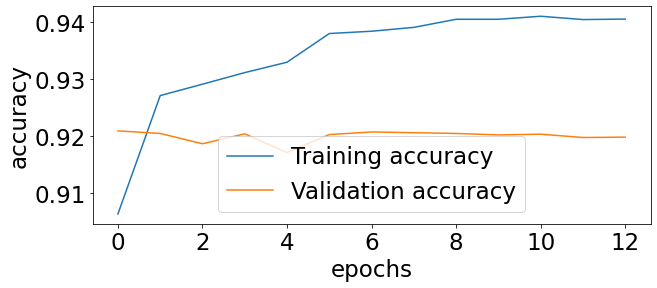

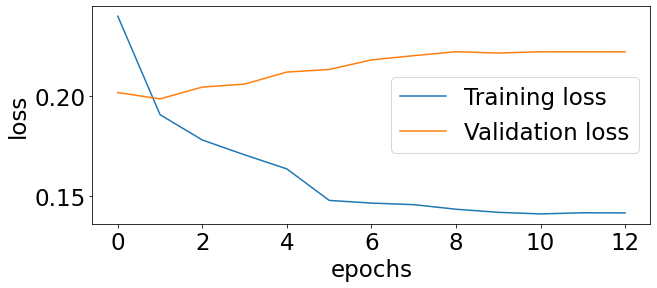

607/607 [==============================] - 2s 3ms/step


 Classification Report for label 'Anomaly_Conflict': 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     15934
           1       0.81      0.71      0.76      3464

    accuracy                           0.92     19398
   macro avg       0.88      0.84      0.86     19398
weighted avg       0.92      0.92      0.92     19398


------- Execution finished for label 'Anomaly_Conflict' ! -------
--- It took 6.7 minutes --- 




In [ ]:
# Test: Call the function on one anomaly label
training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], 
                                               df['Anomaly_Conflict'],
                                               maxlen = 200, 
                                               num_words = 3000, 
                                               N_emb = 200)

------- Execution started for label 'Anomaly_Aircraft Equipment' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [2091, 2870, 2296, 1388, 32, 3, 1086, 1, 106, 1, 198, 792, 401, 85, 735, 710, 334, 87, 74, 79, 717, 87, 74, 111, 220, 966, 83, 1674, 621, 85, 81, 18, 87, 74, 111, 18, 2, 7, 3, 1086, 397, 709, 9, 544, 62, 332, 87, 74, 111, 1102, 2061, 1130, 87, 74, 111, 1713, 1353, 87, 74, 71]
Length: 60

Random examples of entries in X_train:
 [178, 106, 14, 29, 25, 1257, 693, 883, 549, 25, 177, 402, 38, 114, 262, 74, 44, 220, 460, 177, 320, 196, 883, 829, 186, 430, 590, 276, 4, 460, 1563, 484, 239, 20, 646, 4, 2387, 1369, 1246, 79, 154, 24, 31, 717, 175, 208, 89, 292, 1914, 158, 484, 631, 150, 132, 45, 158, 11, 117, 1021]
Length: 59

------------------------------
Sequence

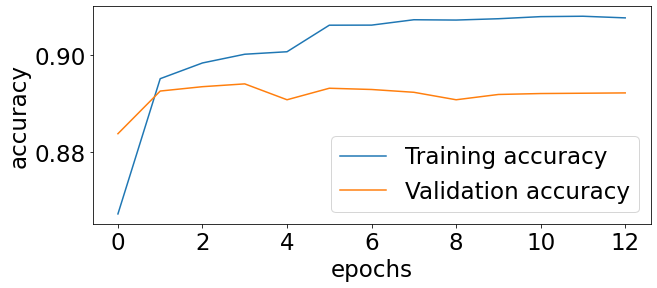

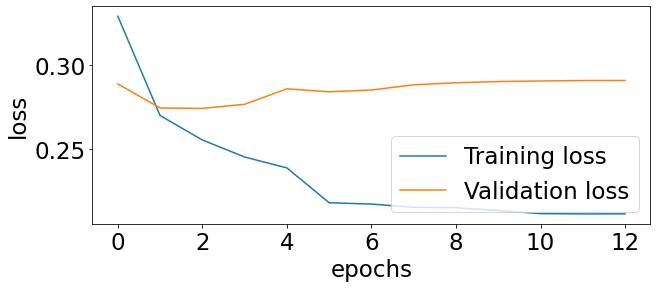

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Aircraft Equipment': 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     11732
           1       0.86      0.88      0.87      7666

    accuracy                           0.89     19398
   macro avg       0.89      0.89      0.89     19398
weighted avg       0.89      0.89      0.89     19398


------- Execution finished for label 'Anomaly_Aircraft Equipment' ! -------
--- It took 2.7 minutes --- 


------- Execution started for label 'Anomaly_Airspace Violation' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [691, 1, 25, 1295, 254, 6, 206, 3, 1548, 110, 3, 745, 1, 1, 106, 260, 1851, 1597, 98, 276, 4, 279, 276, 4, 2

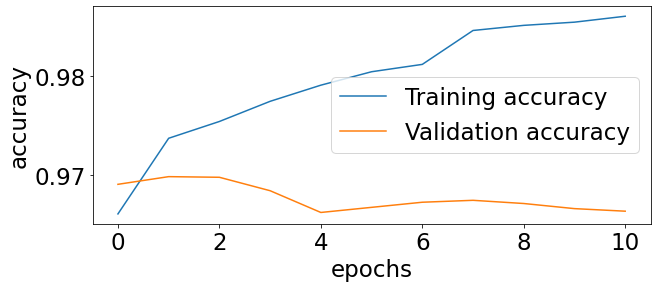

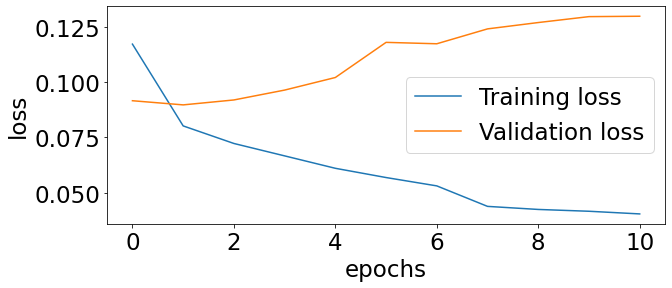

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Airspace Violation': 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     18594
           1       0.77      0.45      0.57       804

    accuracy                           0.97     19398
   macro avg       0.87      0.72      0.78     19398
weighted avg       0.97      0.97      0.97     19398


------- Execution finished for label 'Anomaly_Airspace Violation' ! -------
--- It took 2.1 minutes --- 


------- Execution started for label 'Anomaly_ATC Issue' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [813, 19, 15, 412, 607, 1, 176, 1242, 1040, 216, 790, 1, 1893, 225, 915, 1344, 1360, 1304, 262, 64, 101, 325, 101, 16

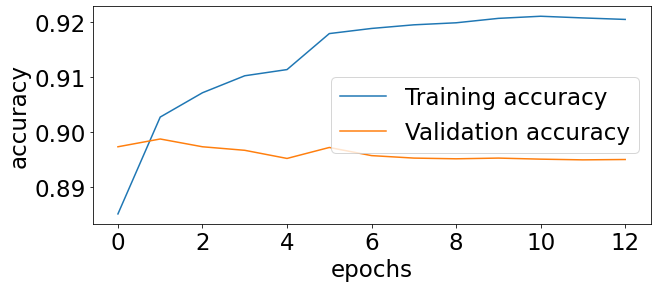

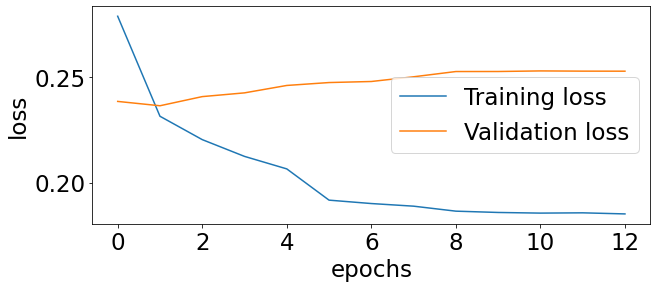

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_ATC Issue': 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     16233
           1       0.74      0.58      0.65      3165

    accuracy                           0.90     19398
   macro avg       0.83      0.77      0.79     19398
weighted avg       0.89      0.90      0.89     19398


------- Execution finished for label 'Anomaly_ATC Issue' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_Flight Deck / Cabin / Aircraft Event' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [119, 344, 6, 80, 575, 583, 63, 449, 80, 369, 537, 722, 80, 201, 1197, 2137, 72, 51, 51, 6, 508, 21, 2, 511,

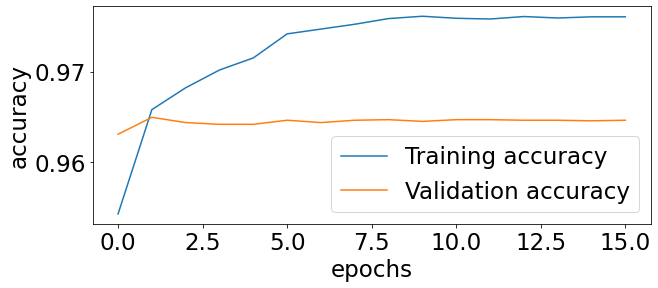

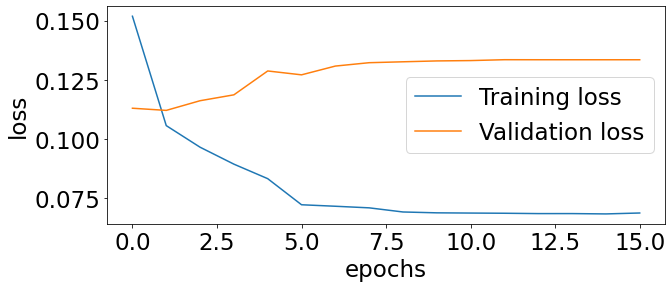

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Flight Deck / Cabin / Aircraft Event': 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     17883
           1       0.84      0.60      0.70      1515

    accuracy                           0.96     19398
   macro avg       0.90      0.80      0.84     19398
weighted avg       0.96      0.96      0.96     19398


------- Execution finished for label 'Anomaly_Flight Deck / Cabin / Aircraft Event' ! -------
--- It took 3.0 minutes --- 


------- Execution started for label 'Anomaly_Conflict' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [43, 2408, 138, 40, 11, 2297, 828, 1, 585, 40, 8, 35, 89, 2740, 43, 1820, 35, 1725

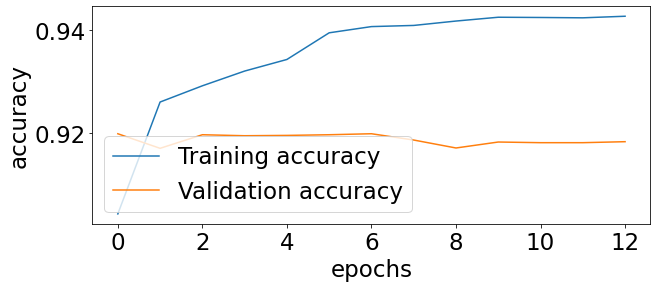

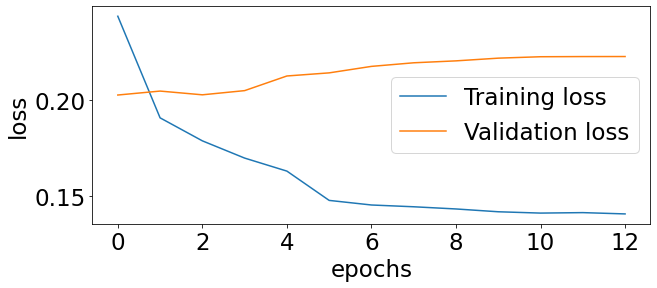

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Conflict': 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     15934
           1       0.81      0.72      0.76      3464

    accuracy                           0.92     19398
   macro avg       0.88      0.84      0.86     19398
weighted avg       0.92      0.92      0.92     19398


------- Execution finished for label 'Anomaly_Conflict' ! -------
--- It took 2.5 minutes --- 


------- Execution started for label 'Anomaly_Deviation - Altitude' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [14, 29, 3, 1207, 18, 30, 111, 2, 184, 8, 2, 247, 52, 1166, 412, 696, 10, 90, 1340, 2, 320, 6, 3, 1190, 586, 689, 9, 87, 74, 3

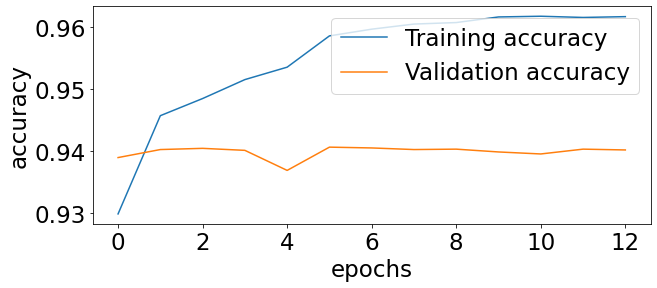

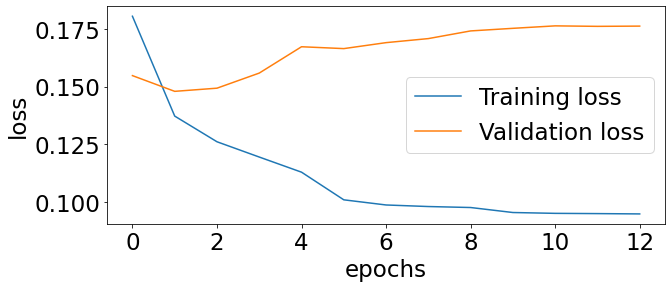

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Deviation - Altitude': 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17666
           1       0.75      0.57      0.65      1732

    accuracy                           0.94     19398
   macro avg       0.85      0.78      0.81     19398
weighted avg       0.94      0.94      0.94     19398


------- Execution finished for label 'Anomaly_Deviation - Altitude' ! -------
--- It took 2.5 minutes --- 


------- Execution started for label 'Anomaly_Deviation - Speed' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [219, 1, 16, 48, 108, 97, 3, 2192, 184, 1, 820, 23, 48, 2, 1608, 438, 557, 144, 1, 124, 48, 97, 1456, 2, 

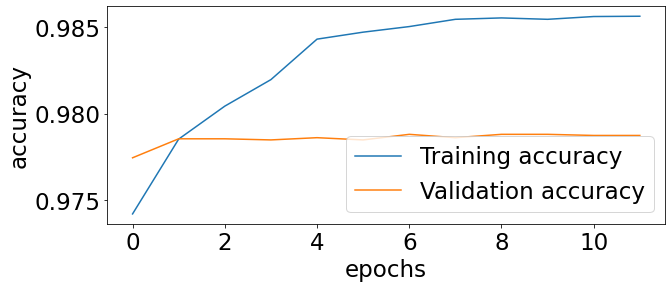

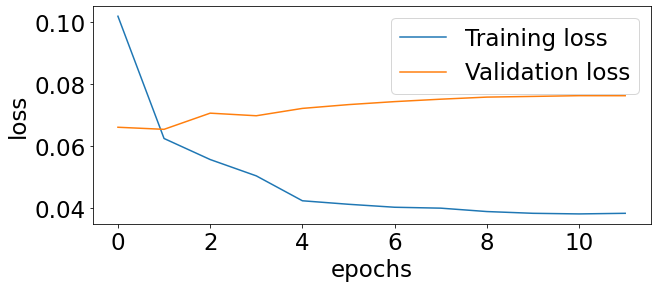

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Deviation - Speed': 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     18873
           1       0.59      0.41      0.48       525

    accuracy                           0.98     19398
   macro avg       0.79      0.70      0.73     19398
weighted avg       0.97      0.98      0.97     19398


------- Execution finished for label 'Anomaly_Deviation - Speed' ! -------
--- It took 2.3 minutes --- 


------- Execution started for label 'Anomaly_Deviation - Track / Heading' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [1815, 429, 6, 3, 3, 328, 212, 85, 1, 871, 164, 74, 87, 914, 3, 3, 704, 2, 1274, 390, 3, 3, 209, 6, 3

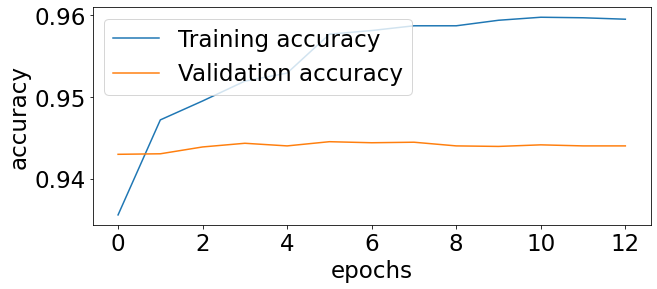

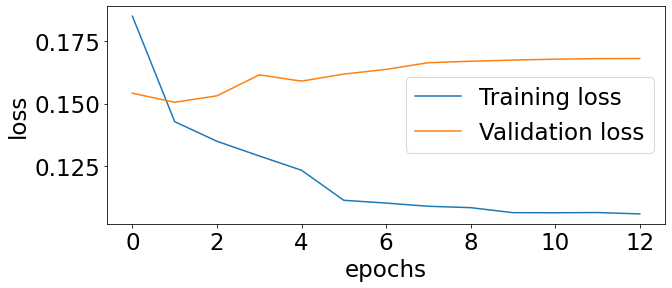

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Deviation - Track / Heading': 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17788
           1       0.72      0.55      0.63      1610

    accuracy                           0.95     19398
   macro avg       0.84      0.77      0.80     19398
weighted avg       0.94      0.95      0.94     19398


------- Execution finished for label 'Anomaly_Deviation - Track / Heading' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_Deviation / Discrepancy - Procedural' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [268, 17, 95, 32, 101, 167, 386, 29, 3, 3, 14, 44, 72, 51, 44, 42, 101, 

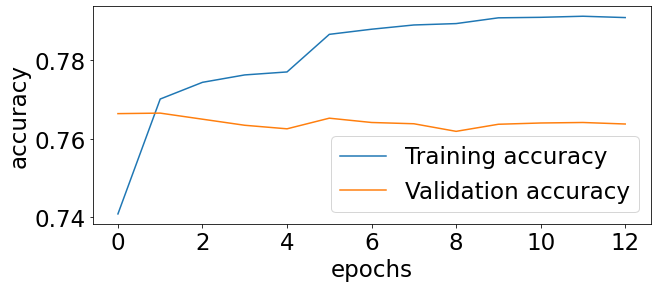

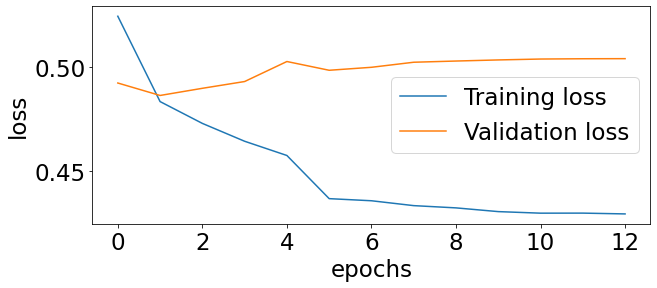

607/607 [==============================] - 1s 1ms/step


 Classification Report for label 'Anomaly_Deviation / Discrepancy - Procedural': 
               precision    recall  f1-score   support

           0       0.72      0.66      0.69      7747
           1       0.79      0.83      0.81     11651

    accuracy                           0.76     19398
   macro avg       0.75      0.74      0.75     19398
weighted avg       0.76      0.76      0.76     19398


------- Execution finished for label 'Anomaly_Deviation / Discrepancy - Procedural' ! -------
--- It took 2.6 minutes --- 


------- Execution started for label 'Anomaly_Ground Excursion' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [30, 644, 296, 329, 1301, 97, 3, 3, 905, 5, 105, 206, 3, 3, 1886, 5, 105, 

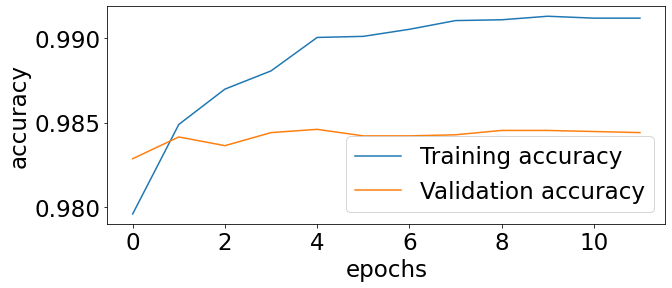

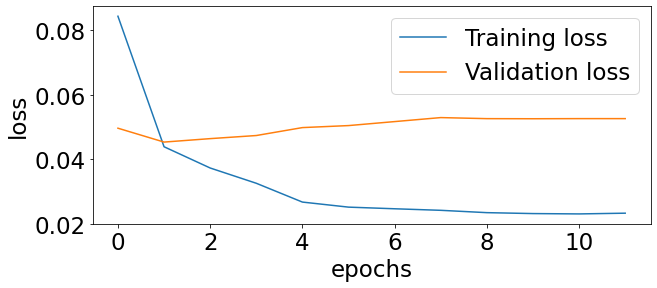

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_Ground Excursion': 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18961
           1       0.73      0.57      0.64       437

    accuracy                           0.99     19398
   macro avg       0.86      0.78      0.82     19398
weighted avg       0.98      0.99      0.98     19398


------- Execution finished for label 'Anomaly_Ground Excursion' ! -------
--- It took 2.4 minutes --- 


------- Execution started for label 'Anomaly_Ground Incursion' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [32, 7, 187, 79, 34, 235, 77, 187, 47, 195, 187, 628, 16, 382, 149, 392, 115, 58, 83, 688, 235, 77, 220, 59, 1, 16

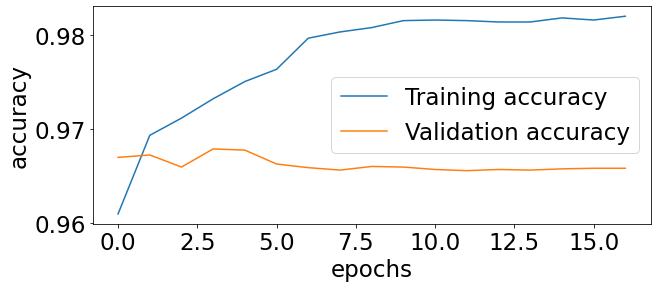

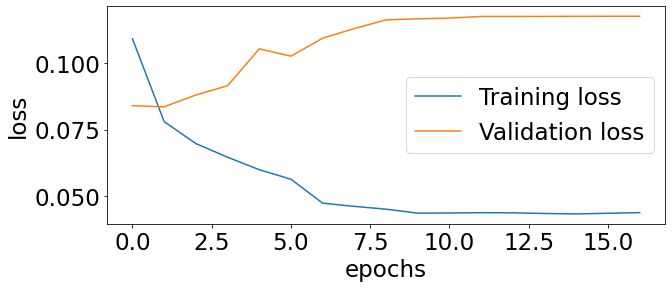

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_Ground Incursion': 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18322
           1       0.70      0.64      0.67      1076

    accuracy                           0.96     19398
   macro avg       0.84      0.81      0.83     19398
weighted avg       0.96      0.96      0.96     19398


------- Execution finished for label 'Anomaly_Ground Incursion' ! -------
--- It took 3.7 minutes --- 


------- Execution started for label 'Anomaly_Ground Event / Encounter' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [42, 466, 1, 2327, 1392, 880, 38, 582, 466, 86, 106, 363, 1, 2346, 1392, 1, 2386, 310, 2386, 1, 1, 2386, 9

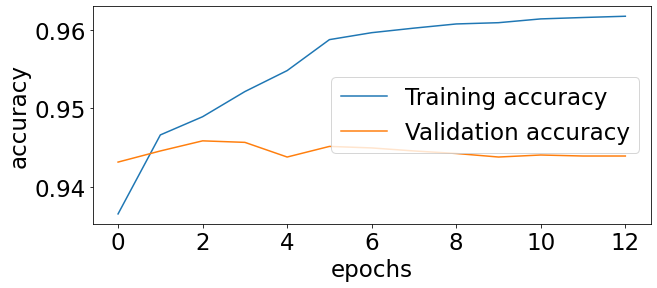

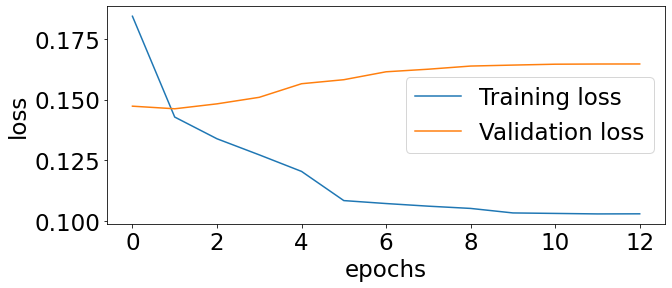

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_Ground Event / Encounter': 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17914
           1       0.68      0.50      0.58      1484

    accuracy                           0.94     19398
   macro avg       0.82      0.74      0.77     19398
weighted avg       0.94      0.94      0.94     19398


------- Execution finished for label 'Anomaly_Ground Event / Encounter' ! -------
--- It took 3.7 minutes --- 


------- Execution started for label 'Anomaly_Inflight Event / Encounter' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [34, 543, 1324, 55, 50, 1815, 429, 5, 1, 1, 5, 120, 89, 1772, 36, 99, 962, 345, 139, 314

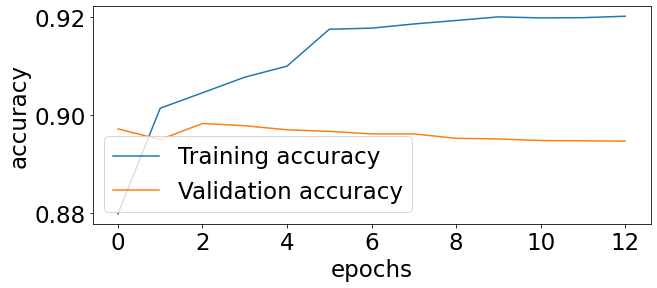

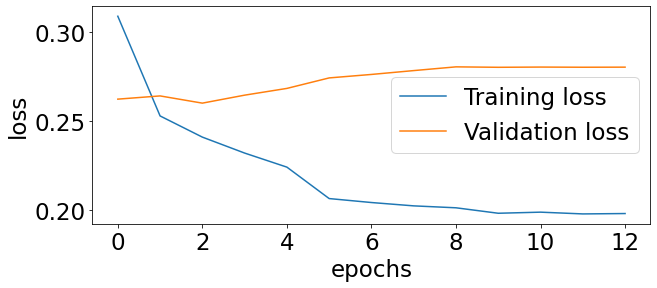

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_Inflight Event / Encounter': 
               precision    recall  f1-score   support

           0       0.91      0.96      0.94     15963
           1       0.78      0.58      0.67      3435

    accuracy                           0.90     19398
   macro avg       0.85      0.77      0.80     19398
weighted avg       0.89      0.90      0.89     19398


------- Execution finished for label 'Anomaly_Inflight Event / Encounter' ! -------
--- It took 2.8 minutes --- 


------- Execution started for label 'Anomaly_No Specific Anomaly Occurred' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [76, 474, 48, 207, 6, 110, 3, 810, 116, 3, 29, 27, 2162, 48, 93, 2408, 184, 18, 29

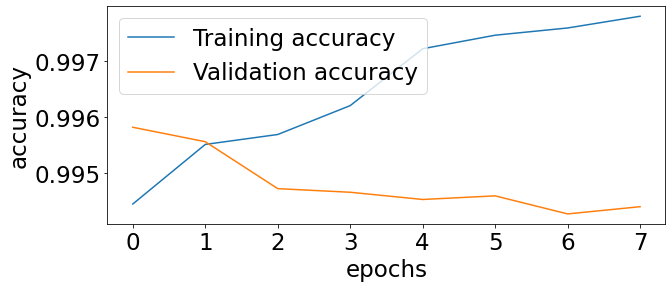

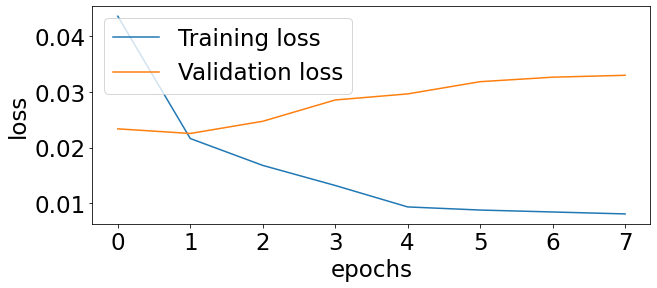

607/607 [==============================] - 1s 2ms/step


 Classification Report for label 'Anomaly_No Specific Anomaly Occurred': 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     19273
           1       0.00      0.00      0.00       125

    accuracy                           0.99     19398
   macro avg       0.50      0.50      0.50     19398
weighted avg       0.99      0.99      0.99     19398


------- Execution finished for label 'Anomaly_No Specific Anomaly Occurred' ! -------
--- It took 1.9 minutes --- 




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
# /!\ takes time to run!
# Call the function looping on all anomalies
# list of metrics DataFrames of our experiment
metrics_df_list = []

for anomaly in Anomaly_RootLabels_columns:
  training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], df[anomaly])
  metrics_df_list.append(metrics)

metrics_exp = pd.concat(metrics_df_list)
# Reset index, otherwise you get a repetition of 0,1,2,3
metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

### Save the data externally

In [ ]:
# # save the df externally
# ##########################################################
# # WARNING!! 
# # If you execute this cell, you will OVERWRITTE the data!
# ##########################################################

# %cd /content/drive/MyDrive/data/transformed/model_results/

# with open("metrics_WordEmbedding_20220727_1700.pkl", "wb") as f:
#     pkl.dump([metrics_exp], f) # saves the variables into a list

/content/drive/MyDrive/data/transformed/model_results


In [ ]:
metrics_exp.head(3)

,classifier,preprocessing,undersampling,Count_Vectorizer_opts,anomaly,metric,0,1,accuracy,macro avg,weighted avg
0,Word_Embedding,1,0,NaN,Anomaly_Aircraft Equipment,precision,0.919552,0.855746,0.893649,0.887649,0.894336
1,Word_Embedding,1,0,NaN,Anomaly_Aircraft Equipment,recall,0.903171,0.879076,0.893649,0.891124,0.893649
2,Word_Embedding,1,0,NaN,Anomaly_Aircraft Equipment,f1-score,0.911288,0.867254,0.893649,0.889271,0.893886


### Plot scores

In [ ]:
def plot_scores_bokeh(metrics_list, metrics_exp):

  # Select sub-DataFrame corresponding to a given metric
  for metric in ['precision', 'recall', 'f1-score', 'support']:
    sub_df = metrics_exp[metrics_exp['metric'] == metric]


    # Listes de données
    modalites = sub_df['anomaly'].unique().tolist()
    valeur1 = sub_df['0']                 # valeur 1 de chaque modalité
    valeur2 = sub_df['1']                 # valeur 2 de chaque modalité
    valeur3 = sub_df['macro avg']         # valeur 3 de chaque modalité

    source = ColumnDataSource({'x' : modalites, 
                              'valeur 1' : valeur1, 
                              'valeur 2' : valeur2, 
                              'valeur 3' : valeur3
                              })
    f = figure(title = f'{metric}',
               width = 800, height = 500, 
               x_range = modalites)
    f.title.text_font_size = '14pt'
    f.xaxis.major_label_orientation = math.pi/3

    #Créer les dictionnaires d'abscisses abscisses_1, abscisses_2 et abscisses_3 décalées respectivement de -0.25, 0 et 0.25. Chaque appel de cette fonction devra prendre en argument du paramètre range l'étendue de l'axe des abscisses de la figure instanciée précédemment et 'x' en argument du paramètre field_name. Ceci permettra à la méthode glyph de faire le lien entre la source et le décalage à appliquer.

    from bokeh.transform import dodge

    abcisses1 = dodge(field_name = 'x', value = -0.25, range = f.x_range)
    abcisses2 = dodge(field_name = 'x', value = 0, range = f.x_range)
    abcisses3 = dodge(field_name = 'x', value = 0.25, range = f.x_range)


    f.vbar(source = source, x = abcisses1, top = 'valeur 1', width = 0.2, color = '#16a3e0', legend_label = "0")
    f.vbar(source = source, x = abcisses2, top = 'valeur 2', width = 0.2, color = '#962c61', legend_label = "1")
    f.vbar(source = source, x = abcisses3, top = 'valeur 3', width = 0.2, color = '#33cccc', legend_label = "macro avg")

    f.legend.location ='top_right'
    show(f)

In [ ]:
# Call the plot function
metrics_list = ['precision', 'recall', 'f1-score', 'support']
plot_scores_bokeh(metrics_list, metrics_exp)

# Multiclass, multilabel classification with Word Embedding


In [ ]:
anomalies = [ 'Anomaly_Aircraft Equipment', 
              'Anomaly_Airspace Violation',
              'Anomaly_ATC Issue', 
              'Anomaly_Flight Deck / Cabin / Aircraft Event',
              'Anomaly_Conflict', 
              'Anomaly_Deviation - Altitude',
              'Anomaly_Deviation - Speed', 
              'Anomaly_Deviation - Track / Heading',
              'Anomaly_Deviation / Discrepancy - Procedural',
              'Anomaly_Ground Excursion', 
              'Anomaly_Ground Incursion',
              'Anomaly_Ground Event / Encounter',
              'Anomaly_Inflight Event / Encounter',
              'Anomaly_No Specific Anomaly Occurred']
# I got this list from df.columns
# 14 labels

In [ ]:
target = df[anomalies].values
print(target[7:10]) # There are indeed multiple labels for one narrative
print("Shape of target:", target.shape)

[[0 1 1 0 1 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 1 0 0 0 0 0]]
Shape of target: (96986, 14)
